# Trading Efficiency vs Time

This notebook creates the supplimental charts at the end of the paper.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from research_tools import storage

pd.options.display.float_format = lambda x: '{:,.4f}'.format(x) if abs(x) < 1 else '{:,.2f}'.format(x)

# Load Data

In [2]:
os.chdir('..')

basename = 'dem'

dem_replicating_contracts, dem_trader_efficiency = storage.retrieve_all(
    [basename + '.replicating_contracts',
     basename + '.trader_efficiency'])

basename = 'gop'

rep_replicating_contracts, rep_trader_efficiency = storage.retrieve_all(
    [basename + '.replicating_contracts',
     basename + '.trader_efficiency'])

Reading data from data/dem.replicating_contracts.p
Reading data from data/dem.trader_efficiency.p
Reading data from data/gop.replicating_contracts.p
Reading data from data/gop.trader_efficiency.p


In [3]:
dem_trader_analysis3_yes = dem_replicating_contracts['yes contracts spreads and fees']
dem_trader_analysis3_no = dem_replicating_contracts['no contracts spreads and fees']

rep_trader_analysis3_yes = rep_replicating_contracts['yes contracts spreads and fees']
rep_trader_analysis3_no = rep_replicating_contracts['no contracts spreads and fees']

# Determine Trading Efficiency

For each trade, determine if it is considered an efficient trade or not.

In [4]:
dem_trader_analysis3_yes[('replication', 'dominated')] = (
    dem_trader_analysis3_yes[('_trades', 'price_per_share')] > dem_trader_analysis3_yes[('replication', 'max_loss')]
)

rep_trader_analysis3_yes[('replication', 'dominated')] = (
    rep_trader_analysis3_yes[('_trades', 'price_per_share')] > rep_trader_analysis3_yes[('replication', 'max_loss')]
)

dem_trader_analysis3_yes[('_trades', 'day_of_trade')] = (
    dem_trader_analysis3_yes[('_trades', 'date_executed')].dt.date
)

rep_trader_analysis3_yes[('_trades', 'day_of_trade')] = (
    rep_trader_analysis3_yes[('_trades', 'date_executed')].dt.date
)

In [5]:
replication_share_qty_cutoff = 10

def get_max_value(d_dict):
    try:
        d_dict = eval(d_dict)
        d_dict.pop('contracts')
        return max(d_dict.values())
    except:
        return np.nan

def get_contract_type(d_dict):
    try:
        d_dict = eval(d_dict)
        return d_dict.pop('contracts')
    except:
        return 'NEITHER'

dem_trader_analysis3_no[('replication', 'dominated_yes')] = (
    (dem_trader_analysis3_no[('_trades', 'price_per_share')] > dem_trader_analysis3_no[('replication', 'max_loss')]) &
    (dem_trader_analysis3_no[('replication', 'd')].apply(get_max_value) < replication_share_qty_cutoff) &
    (dem_trader_analysis3_no[('replication', 'd')].apply(get_contract_type) == 'YES')
)

dem_trader_analysis3_no[('replication', 'dominated_no')] = (
    (dem_trader_analysis3_no[('_trades', 'price_per_share')] > dem_trader_analysis3_no[('replication', 'max_loss')]) &
    (dem_trader_analysis3_no[('replication', 'd')].apply(get_max_value) < replication_share_qty_cutoff) &
    (dem_trader_analysis3_no[('replication', 'd')].apply(get_contract_type) == 'NO')
)

In [6]:
dem_trader_analysis3_yes_subset = dem_trader_analysis3_yes[[('_trades', 'day_of_trade'), ('replication', 'dominated'), ('_trades', 'quantity')]]
rep_trader_analysis3_yes_subset = rep_trader_analysis3_yes[[('_trades', 'day_of_trade'), ('replication', 'dominated'), ('_trades', 'quantity')]]

dem_trader_analysis3_yes_subset.columns = 'day_of_trade dominated quantity'.split()
rep_trader_analysis3_yes_subset.columns = 'day_of_trade dominated quantity'.split()

dem_trader_analysis3_yes_subset.head()

day_of_trade dominated  quantity
contract_id user_guid                                                            
840         005E56D2-76B6-39DA-9199-366D761FE63D   2015-09-07      True        30
            005E56D2-76B6-39DA-9199-366D761FE63D   2015-09-07      True        10
            005E56D2-76B6-39DA-9199-366D761FE63D   2015-09-07      True       100
            005E56D2-76B6-39DA-9199-366D761FE63D   2015-09-07      True       100
            006963F5-467A-3331-B78D-B1152A3EA9BD   2015-09-17      True        10

# Volume per day by Efficiency Designation of Trader

For each market, how much volume was executed each day by traders designated as efficient or inefficient in the final analysis?

In [7]:
dem_efficiency_by_day = (
    dem_trader_analysis3_yes_subset.join((dem_trader_efficiency > 0.75).to_frame('efficient_trader'))
    .groupby(['day_of_trade', 'efficient_trader'])['quantity']
    .sum().unstack().fillna(0)
)

rep_efficiency_by_day = (
    rep_trader_analysis3_yes_subset.join((dem_trader_efficiency > 0.75).to_frame('efficient_trader'))
    .groupby(['day_of_trade', 'efficient_trader'])['quantity']
    .sum().unstack().fillna(0)
)

dem_efficiency_by_day.columns = 'inefficient_trader_volume efficient_trader_volume'.split()
rep_efficiency_by_day.columns = 'inefficient_trader_volume efficient_trader_volume'.split()
dem_efficiency_by_day.index = pd.to_datetime(dem_efficiency_by_day.index)
rep_efficiency_by_day.index = pd.to_datetime(rep_efficiency_by_day.index)

dem_efficiency_by_day.head()

,inefficient_trader_volume,efficient_trader_volume
day_of_trade,,
2015-06-17,11.00,113.00
2015-06-18,51.00,158.00
2015-06-19,125.00,5.00
2015-06-20,0.0000,145.00
2015-06-21,0.0000,37.00


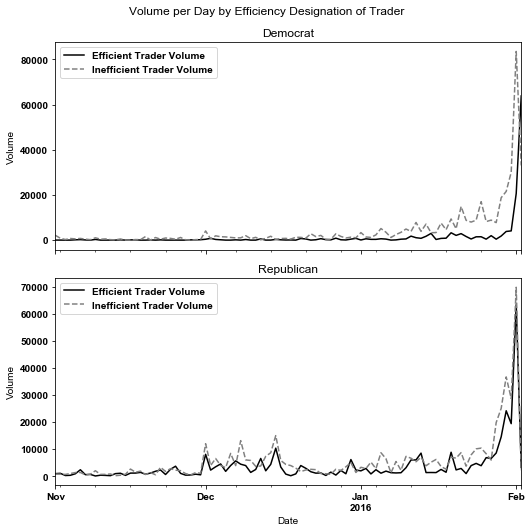

In [8]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

legend_elements = [
    Line2D([0], [0], linestyle='-', color='black', label='Efficient Trader Volume'),
    Line2D([0], [0], linestyle='--', color='gray', label='Inefficient Trader Volume')
]

fig = plt.figure(figsize=(7.5, 7.5))

ax1 = plt.subplot(211)
plt.suptitle('Volume per Day by Efficiency Designation of Trader')
plt.title('Democrat')

dem_efficiency_by_day.loc['2015-11-01':, 'efficient_trader_volume'].plot(ax=ax1, c='black')
dem_efficiency_by_day.loc['2015-11-01':, 'inefficient_trader_volume'].plot(ax=ax1, c='gray', linestyle='--')

plt.ylabel('Volume')
plt.legend(handles=legend_elements)

ax2 = plt.subplot(212)
plt.title('Republican')

rep_efficiency_by_day.loc['2015-11-01':, 'efficient_trader_volume'].plot(ax=ax2, sharex=ax1, c='black')
rep_efficiency_by_day.loc['2015-11-01':, 'inefficient_trader_volume'].plot(ax=ax2, sharex=ax1, c='gray', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(handles=legend_elements)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.savefig('charts/volume_by_efficiency_designation_of_trader.png', dpi=300)